#  Atak Adwersarialny FGSM na Klasyfikator Obrazów ImageNet

W tym notatniku przeprowadzimy eksperyment z atakiem adwersarialnym **Fast Gradient Sign Method (FGSM)**, aby zademonstrować, jak łatwo można zwieść głęboki model klasyfikacyjny wytrenowany na zbiorze ImageNet. Użyjemy do tego obrazu świni ('pig.jpg') jako przykładu.

###  Cele eksperymentu:

1.  Wczytanie i wstępne przetwarzanie obrazu wejściowego zgodnie z wymaganiami modelu ImageNet.
2.  Wygenerowanie niezauważalnej perturbacji FGSM.
3.  Zastosowanie perturbacji w celu zmiany klasyfikacji obrazu przez model.
4.  Wizualna analiza obrazu oryginalnego, perturbacji i obrazu adwersarialnego.

# Konfiguracja Środowiska i Wczytanie Bibliotek

Przed rozpoczęciem eksperymentu musimy zaimportować niezbędne biblioteki do manipulacji danymi, obsługi PyTorcha oraz wyświetlania obrazów.

### Wymagane pliki:

Aby notatnik działał poprawnie, w katalogu roboczym muszą znajdować się następujące pliki:
* **`pig.jpg`**: Obraz, który będzie celem ataku.
* **`imagenet_class_index.json`**: Plik mapujący indeksy klas na ich nazwy tekstowe w zbiorze ImageNet.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.models import resnet50
from PIL import Image
import json

# Konfiguracja wizualizacji
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

print("Importy zakończone. PyTorch gotowy.")

Importy zakończone. PyTorch gotowy.


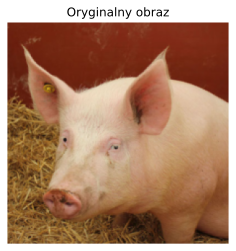

In [4]:
# Wymagane: Pliki 'pig.jpg' i 'imagenet_class_index.json' muszą znajdować się w katalogu roboczym.

# Wczytanie obrazu, skalowanie do 224x224 i konwersja na Tensor
pig_img = Image.open("pig.jpg")
preprocess = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(), # konwersja na Tensor CHW (Channel, Height, Width)
])
# Dodajemy wymiar wsadowy (batch dimension): (1, C, H, W)
pig_tensor = preprocess(pig_img)[None,:,:,:]

# Wyświetlenie oryginalnego obrazu (konwersja z CHW na HWC dla numpy/matplotlib)
plt.figure(figsize=(4,4))
plt.imshow(pig_tensor[0].numpy().transpose(1,2,0))
plt.title("Oryginalny obraz")
plt.axis('off')
plt.show()

#  Ładowanie Modelu i Ustalenie Punktu Bazowego

Aby przeprowadzić atak adwersarialny, musimy najpierw załadować i skonfigurować wstępnie wytrenowany model oraz upewnić się, że poprawnie klasyfikuje oryginalny obraz.

### Moduł Normalizacji

Modele wytrenowane na ImageNet, takie jak **ResNet50**, wymagają standardowej normalizacji danych wejściowych, używającej globalnej średniej (mean) i odchylenia standardowego (std) całego zbioru ImageNet. Zaimplementowany moduł `Normalize` zapewnia, że:
1.  Obraz jest poprawnie skalowany przed podaniem do sieci.
2.  Operacje na tensorach są **śledzone** przez mechanizm autogradu PyTorch, co jest kluczowe dla obliczenia gradientu FGSM.

### Predykcja Bazowa

Po załadowaniu modelu w trybie ewaluacji (`model.eval()`) obliczamy predykcję dla czystego obrazu. Oczekujemy, że model poprawnie sklasyfikuje świnię (klasa 'hog' lub inna pokrewna) z wysoką pewnością, a początkowa strata będzie stosunkowo niska.

In [5]:
# Prosty Moduł do normalizacji obrazu (średnia i odchylenie standardowe ImageNet)
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        # Normalizacja: (x - mean) / std, z rozszerzonymi wymiarami dla broadcastingu
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

# Standardowe wartości normalizacji dla ImageNet
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# Ładowanie wstępnie wytrenowanego ResNet50
model = resnet50(pretrained=True)
# Ustawienie modelu w tryb ewaluacji (wyłączenie np. Batch Normalization i Dropout)
model.eval();

# Obliczenie predykcji modelu bazowego
pred = model(norm(pig_tensor))

# Wczytanie etykiet klas ImageNet
with open("imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}

# Prawdziwa predykcja modelu
max_conf, max_idx = pred.max(dim=1)
predicted_class = imagenet_classes[max_idx.item()]

print(f"Predykcja modelu dla czystego obrazu: {predicted_class}")

# Klasa 341 to "hog" (dzik/świnia), co jest celem ataku
hog_index = 341
# Obliczenie straty CrossEntropy dla prawdziwej klasy (341)
initial_loss = nn.CrossEntropyLoss()(model(norm(pig_tensor)), torch.LongTensor([hog_index])).item()
print(f"Początkowa strata CrossEntropy (dla 'hog'): {initial_loss:.4f}")

C:\Users\Damian\Desktop\AdAttackCourse\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Damian\Desktop\AdAttackCourse\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Predykcja modelu dla czystego obrazu: hog
Początkowa strata CrossEntropy (dla 'hog'): 0.0039


#  Iteracyjny Atak Niekierowany (Metoda PGD)

W celu zwiększenia skuteczności ataku na tak złożonym modelu jak ResNet50, stosujemy **iteracyjną** wersję ataku, która jest zbliżona do metody **Projected Gradient Descent (PGD)** – często uznawanej za silniejszą formę ataku FGSM.

### Limit Perturbacji $L_\infty$

Aby zapewnić, że perturbacja ($\delta$) pozostanie **niezauważalna dla ludzkiego oka**, wprowadzamy rygorystyczny limit $L_\infty$ (norma nieskończoności):
$$\|\delta\|_\infty \leq \epsilon$$
Limit $\epsilon$ wynoszący $2/255$ jest bardzo mały i oznacza, że każdy piksel w obrazie może zostać zmieniony maksymalnie o 2 wartości skali $0-255$.

### Logika Ataku

Atak jest **niekierowany** (ang. *untargeted*). Celem optymalizacji jest:
* **Maksymalizacja straty** $J$ dla poprawnej klasy (w tym przypadku: 'hog').
* W kodzie osiągamy to poprzez **minimalizację ujemnej straty** (tj. `loss = -nn.CrossEntropyLoss()`).

Po każdej iteracji gradientu i aktualizacji, perturbacja ($\delta$) jest **przycinana** (`clamp_`) do zakresu $\pm \epsilon$, aby utrzymać subtelność ataku.

In [6]:
# Limit epsilon dla perturbacji L-inf: 2/255
epsilon = 2. / 255

# Inicjalizacja perturbacji (delta) jako tensor zer o tym samym kształcie co obraz
delta = torch.zeros_like(pig_tensor, requires_grad=True)
# Optymalizator będzie uaktualniał tylko delta
opt = optim.SGD([delta], lr=1e-1)

print("Rozpoczęcie iteracyjnego ataku niekierowanego...")
for t in range(30):
    # Obliczenie predykcji dla zniekształconego obrazu
    pred = model(norm(pig_tensor + delta))
    # Cel: Maksymalizuj stratę dla prawdziwej klasy (341), czyli minimalizuj UJEMNĄ stratę
    loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([hog_index]))

    if t % 5 == 0:
        print(f"Epoka {t}: Ujemna strata (Loss): {loss.item():.4f}") # Im niższa, tym skuteczniejszy atak

    opt.zero_grad()
    loss.backward() # Obliczenie gradientów
    opt.step()      # Aktualizacja delty w kierunku ujemnego gradientu straty (w górę)

    # Przycięcie delty do zdefiniowanego limitu epsilon L-inf
    delta.data.clamp_(-epsilon, epsilon)

# Końcowe podsumowanie ataku niekierowanego
final_prob_hog = nn.Softmax(dim=1)(pred)[0, hog_index].item()
max_class = pred.max(dim=1)[1].item()

print("\n--- Wyniki Ataku Niekierowanego ---")
print(f"Prawdopodobieństwo prawdziwej klasy ('hog'): {final_prob_hog:.4f}")
print(f"Nowa klasa predykcji: {imagenet_classes[max_class]}")
print(f"Prawdopodobieństwo nowej klasy: {nn.Softmax(dim=1)(pred)[0, max_class].item():.4f}")

Rozpoczęcie iteracyjnego ataku niekierowanego...
Epoka 0: Ujemna strata (Loss): -0.0039
Epoka 5: Ujemna strata (Loss): -0.0069
Epoka 10: Ujemna strata (Loss): -0.0158
Epoka 15: Ujemna strata (Loss): -0.0808
Epoka 20: Ujemna strata (Loss): -11.6271
Epoka 25: Ujemna strata (Loss): -14.6856

--- Wyniki Ataku Niekierowanego ---
Prawdopodobieństwo prawdziwej klasy ('hog'): 0.0000
Nowa klasa predykcji: wombat
Prawdopodobieństwo nowej klasy: 1.0000


#  Iteracyjny Atak Ukierunkowany (Targeted Attack)

Atak ukierunkowany jest bardziej zaawansowany. Jego celem jest nie tylko spowodowanie błędnej klasyfikacji, ale wymuszenie na modelu predykcji **konkretnej, z góry określonej klasy** (w tym przypadku: 'persian cat', indeks 404).

### Zmiana Funkcji Straty

Aby osiągnąć ten cel, funkcja straty ($L$) musi spełniać dwa kryteria jednocześnie:
1.  **Maksymalizować** stratę dla **poprawnej** klasy ($J_{hog}$).
2.  **Minimalizować** stratę dla **docelowej** klasy ($J_{target}$).

Łącząc te cele, tworzymy nową funkcję optymalizacji:
$$L = -J_{hog} + J_{target}$$
Minimalizując tę funkcję ($L$), maksymalizujemy $J_{hog}$ (dzięki ujemnemu znakowi) i minimalizujemy $J_{target}$ (dzięki dodatniemu znakowi). Wymaga to również mniejszego współczynnika uczenia (`lr`) i większej liczby epok dla precyzyjnej zbieżności.

In [7]:
# Ponowna inicjalizacja delty
delta = torch.zeros_like(pig_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=5e-3) # Mniejszy learning rate (lr) i więcej epok dla zbieżności ataku ukierunkowanego

# Klasa docelowa: 404 to "persian cat"
target_index = 404
print(f"Cel Ataku: {imagenet_classes[target_index]} (Indeks: {target_index})")
print("Rozpoczęcie iteracyjnego ataku ukierunkowanego...")

for t in range(100):
    pred = model(norm(pig_tensor + delta))

    # Funkcja straty ukierunkowanego ataku:
    # 1. Maksymalizuj stratę dla PRAWIDŁOWEJ klasy (-nn.CrossEntropyLoss)
    # 2. Minimalizuj stratę dla DOCELOWEJ klasy (+nn.CrossEntropyLoss)
    loss = (-nn.CrossEntropyLoss()(pred, torch.LongTensor([hog_index])) +
            nn.CrossEntropyLoss()(pred, torch.LongTensor([target_index])))

    if t % 10 == 0:
        max_class = pred.max(dim=1)[1].item()
        prob_max = nn.Softmax(dim=1)(pred)[0, max_class].item()
        print(f"Epoka {t}: Loss: {loss.item():.4f} | Pred: {imagenet_classes[max_class]} ({prob_max:.2f})")

    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)

# Końcowe podsumowanie ataku ukierunkowanego
max_class = pred.max(dim=1)[1].item()
final_prob_max = nn.Softmax(dim=1)(pred)[0, max_class].item()
final_prob_target = nn.Softmax(dim=1)(pred)[0, target_index].item()


print("\n--- Wyniki Ataku Ukierunkowanego ---")
print(f"Końcowa klasa predykcji: {imagenet_classes[max_class]}")
print(f"Prawdopodobieństwo predykcji: {final_prob_max:.4f}")
print(f"Prawdopodobieństwo klasy docelowej ('persian cat'): {final_prob_target:.4f}")
print(f"Czy atak się powiódł (trafił w cel)? {max_class == target_index}")

Cel Ataku: airliner (Indeks: 404)
Rozpoczęcie iteracyjnego ataku ukierunkowanego...
Epoka 0: Loss: 24.0060 | Pred: hog (1.00)
Epoka 10: Loss: -0.1204 | Pred: projectile (0.04)
Epoka 20: Loss: -7.9778 | Pred: airliner (0.23)
Epoka 30: Loss: -15.1288 | Pred: airliner (0.58)
Epoka 40: Loss: -21.3368 | Pred: airliner (0.74)
Epoka 50: Loss: -27.3355 | Pred: airliner (0.74)
Epoka 60: Loss: -30.6647 | Pred: airliner (0.81)
Epoka 70: Loss: -33.9989 | Pred: airliner (0.83)
Epoka 80: Loss: -35.8519 | Pred: airliner (0.91)
Epoka 90: Loss: -36.1898 | Pred: airliner (0.96)

--- Wyniki Ataku Ukierunkowanego ---
Końcowa klasa predykcji: airliner
Prawdopodobieństwo predykcji: 0.8644
Prawdopodobieństwo klasy docelowej ('persian cat'): 0.8644
Czy atak się powiódł (trafił w cel)? True


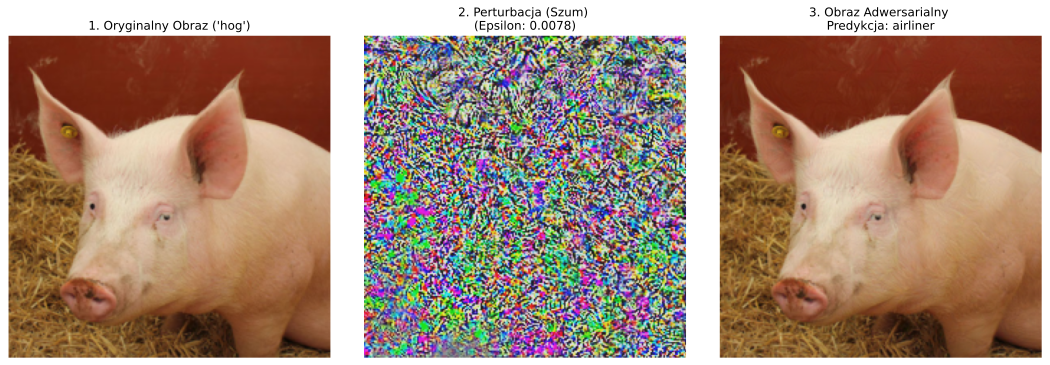

In [9]:
# Konwersja z Tensor CHW na numpy HWC i odłączenie od grafu obliczeniowego
pig_adv_img = (pig_tensor + delta)[0].detach().numpy().transpose(1, 2, 0)
# Wizualizacja samej perturbacji (skalowana dla lepszej widoczności)
delta_viz = (50 * delta + 0.5)[0].detach().numpy().transpose(1, 2, 0)

f, ax = plt.subplots(1, 3, figsize=(15, 5))

# 1. Oryginalny obraz
ax[0].imshow(pig_tensor[0].detach().numpy().transpose(1, 2, 0))
ax[0].set_title("1. Oryginalny Obraz ('hog')")
ax[0].axis('off')

# 2. Perturbacja (skalowana x50)
ax[1].imshow(delta_viz)
ax[1].set_title(f"2. Perturbacja (Szum) \n(Epsilon: {epsilon:.4f})")
ax[1].axis('off')

# 3. Obraz Adwersarialny
ax[2].imshow(pig_adv_img)
ax[2].set_title(f"3. Obraz Adwersarialny \nPredykcja: {imagenet_classes[max_class]}")
ax[2].axis('off')

plt.tight_layout()
plt.show()